In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from kan import KAN
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

torch.manual_seed(42)
np.random.seed(42)

device: cuda


In [2]:
model_name = "KAN"           # "MLP" or "KAN"
window_size = 20             # order of AR model
num_epochs = 300
sigma = 0.4

# Generate data
n_points = 500
x = np.linspace(0, 8 * np.pi, n_points)
noise = np.random.normal(0, sigma, n_points)
y = np.cos(2 * x) + np.cos(2 * np.pi * x) + noise
# y = np.sin(3 * x) + np.sin(2 * np.e * x) + noise

# Create sliding window dataset
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Generate sequence data
X, y = create_sequences(y, window_size)

# Split data into training and testing sets
n_train = 400 - window_size
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

# Normalize data
X_mean, X_std = X_train.mean(), X_train.std()
y_mean, y_std = y_train.mean(), y_train.std()

X_train_norm = (X_train - X_mean) / X_std
y_train_norm = (y_train - y_mean) / y_std
X_test_norm = (X_test - X_mean) / X_std

# ================== New Section: Train AR Model to Obtain Weights ==================
# Use linear regression as the AR(window_size) model
ar_model = LinearRegression(fit_intercept=False)  # No intercept needed after normalization
ar_model.fit(X_train_norm, y_train_norm)
ar_weights = ar_model.coef_.flatten()

print("AR model weights:", ar_weights)

# Apply AR weights to input data
def apply_ar_weights(data, weights):
    """Apply AR weights to input data"""
    return data * weights

# Apply AR weight transformation
X_train_ar = apply_ar_weights(X_train_norm, ar_weights)
X_test_ar = apply_ar_weights(X_test_norm, ar_weights)

# Convert transformed data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_ar).to(device)
y_train_tensor = torch.FloatTensor(y_train_norm.reshape(-1, 1)).to(device)
X_test_tensor = torch.FloatTensor(X_test_ar).to(device)
# ===============================================================

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define MLP model - Modify input dimension to window_size
class MLP(nn.Module):
    def __init__(self, window_size):
        super(MLP, self).__init__()
        # Input dimension is window_size because each feature is retained after AR transformation
        self.model = nn.Sequential(
            nn.Linear(window_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize model, loss function, and optimizer
if model_name == "MLP":
    model = MLP(window_size).to(device)
elif model_name == "KAN":
    model = KAN(width=[window_size, 50, 1], grid=3, k=3, auto_save=False).to(device)
else:
    raise ValueError("Invalid model name. Choose 'MLP' or 'KAN'.")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses = []

# Use tqdm to create a progress bar
with tqdm(range(num_epochs), desc="Training Progress", unit="epoch") as pbar:
    for epoch in pbar:
        model.train()
        epoch_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        
        # Dynamically update loss on the progress bar
        pbar.set_postfix(loss=avg_epoch_loss)

# Evaluate the model and make predictions
model.eval()
with torch.no_grad():
    # Training set predictions
    train_predictions = model(X_train_tensor).cpu().numpy() * y_std + y_mean
    
    # Perform step-by-step predictions on the test set
    test_predictions = []
    current_sequence = X_test_norm[0].copy()  # Use the first test sequence as the starting point
    
    for i in range(len(X_test)):
        # Apply AR weight transformation
        current_ar = apply_ar_weights(current_sequence.reshape(1, -1), ar_weights)
        current_tensor = torch.FloatTensor(current_ar).to(device)
        
        next_pred = model(current_tensor).item()
        
        # Denormalize the prediction result
        next_pred_denorm = next_pred * y_std + y_mean
        test_predictions.append(next_pred_denorm)
        
        # Update the sequence (remove the earliest value, add the new predicted value)
        if i < len(X_test) - 1:
            # Get the next real value (used for the next prediction)
            next_real = X_test_norm[i+1][-1]  # Use the last element of the next sequence (i.e., the newest value)
            # Update the sequence: remove the first element, add the next real value
            current_sequence = np.append(current_sequence[1:], next_real)

# Prepare indices for the original time series and prediction results for proper visualization
train_indices = np.arange(window_size, window_size + len(train_predictions))
test_indices = np.arange(window_size + len(train_predictions), n_points)

# Calculate MSE for the test set
test_mse = ((np.array(test_predictions) - y_test) ** 2).mean()
print(f'Test set MSE: {test_mse:.4f}')

AR model weights: [-0.22542156 -0.1177235   0.044958    0.08311094  0.11919916  0.09447204
  0.11376806  0.03371057 -0.01706208 -0.01555468 -0.09828425 -0.08981706
 -0.19629925 -0.08547888  0.03550235  0.08191243  0.02841599  0.24099864
  0.35850444  0.37821677]


Training Progress: 100%|██████████| 300/300 [48:48<00:00,  9.76s/epoch, loss=0.18] 


Test set MSE: 0.2892


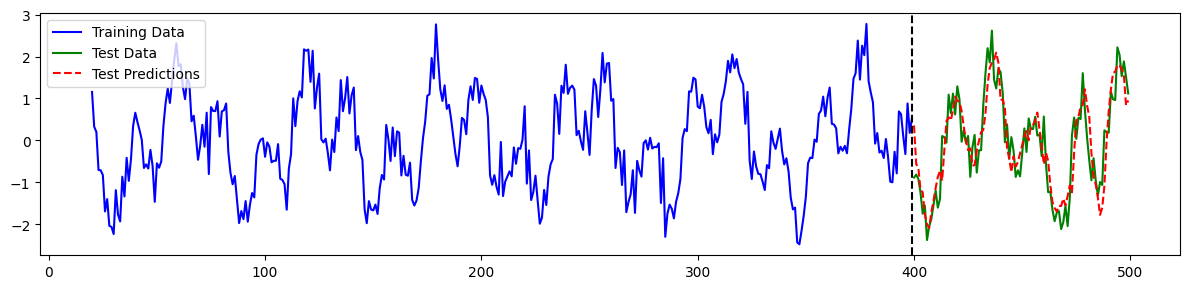

In [3]:
# Draw
plt.figure(figsize=(12, 3))

plt.plot(range(window_size, window_size + len(y_train)), y_train, 'b-', label='Training Data')
plt.plot(range(window_size + len(y_train), window_size + len(y_train) + len(y_test)), y_test, 'g-', label='Test Data')
plt.plot(test_indices, test_predictions, 'r--', label='Test Predictions')
plt.axvline(x=train_indices[-1], color='k', linestyle='--')

plt.legend()
plt.tight_layout()
plt.show()